# My solution for Advanced Lane Finding Project



The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [78]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import linear_model
from scipy import stats
from collections import deque

from glob import glob
%matplotlib inline

## Step 1 Camera Calibration

Giving the multiple cheesboard images, I make use of all to firstly calculate the camera matrix and the distortion coefficients. Then, image can be undistorted accordingly. [OpenCV doc](https://docs.opencv.org/3.4.3/dc/dbb/tutorial_py_calibration.html)

In [3]:
def camera_cal(cal_dir, nx, ny):
    """ camera calibration based on multiple chessboard images
    https://docs.opencv.org/3.4.3/dc/dbb/tutorial_py_calibration.html
    input:
        cal_dir: input image directory 
        nx: number of corners in a row 
        ny: number of corners in a column

    return:
        mtx: camera matrix
        dist: distortion coefficients

    """
    img_paths = glob(cal_dir + '/calibration*.jpg')

    # print(img_paths)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for path in img_paths:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            objpoints.append(objp)
            imgpoints.append(corners)

            # cv2.imshow('img', img)
            # cv2.waitKey(500)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (ret, mtx, dist, rvecs, tvecs)

In [6]:
def test_camera_cal():
    """ test function for camera calibration """
    
    img_dir = './camera_cal'

    cal_img = './camera_cal/calibration1.jpg'

    img = cv2.imread(cal_img)

    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # cv2.imshow('img', dst)
    # cv2.waitKey(0)
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.set_title('Distorted image')
    ax1.imshow(img[...,::-1])

    ax2.set_title('Undistorted image')
    ax2.imshow(dst[...,::-1])

    plt.tight_layout()
#     plt.savefig('./output_images/cameral_calibration.png')
    plt.show()


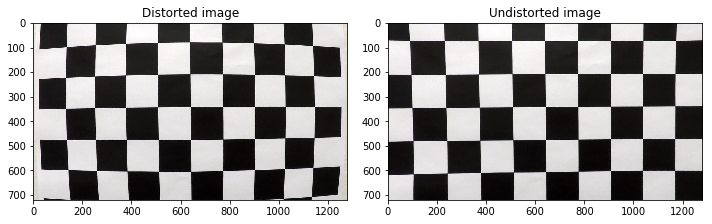

In [7]:
test_camera_cal()

## Step 2 Binary images of roads

After undistorting all the test images, in this step I create binary images of roads based on color and gradient thresholding.
Here I make use three thresholding operation:

* Absolute values of gradients along the x direction by Sobel Operation.
* S channel values of images converted into HLS color space.
* Gradient angle values.

  
Since the directions of roads in the view of the vehicle are almost verticle, gradient values along the x direction and gradient angle values can help to threshold road areas. Also, by converting images from RGB to HLS color space, it is more robust to lighting change for color selection than just thresholding in RGB space. 

In [9]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """ thresholding method based on gradients of image in x or y direction
    input:
        img: BGR img read by cv2
        orient: 'x' or 'y'
        sobel_kernel: size of sobel kernel
        thresh: low and upper thresholds for absolute values of derivatives
    
    output:
        binary_output: binary map of preserved values in-between the thresholds
    """


    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        img_gray_x_deriv = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
        img_gray_x_deriv = np.uint8(255*np.absolute(img_gray_x_deriv)/np.max(np.absolute(img_gray_x_deriv)))
        binary_output = np.zeros_like(img_gray_x_deriv) # Remove this line
        binary_output[(img_gray_x_deriv>thresh[0])&(img_gray_x_deriv<thresh[1])] = 1
    else:
        img_gray_y_deriv = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
        img_gray_y_deriv = np.uint8(255*np.absolute(img_gray_y_deriv)/np.max(np.absolute(img_gray_y_deriv)))
        binary_output = np.zeros_like(img_gray_y_deriv) # Remove this line
        binary_output[(img_gray_y_deriv>thresh[0])&(img_gray_y_deriv<thresh[1])] = 1

    return binary_output


In [11]:
def hls_thres(img, thresh=(0, 255)):
    """ thresholding based on S channel value of HLS image 
    Input:
        img: BGR image read by cv2
        thresh: low and upper thresholds for values of S channel
    Output:
        binary_output: binary map of preserved values in-between the thresholds
    """

    
    img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S_channel = img_HLS[...,-1]
    binary_output = np.zeros_like(S_channel)
    binary_output[(S_channel>thresh[0])&(S_channel<=thresh[1])] = 1
    
    return binary_output, S_channel

In [12]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """ thresholding method based on direction of derivatives
    Input: 
        image: BGR image read by cv2
        sobel_kernel: size of sobel kernel
        thresh: low and upper thresholds for direction of derivatives
    Output:
        binary_output: binary map of preserved values in-between the thresholds
    """

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    img_gray_x_deriv = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    img_gray_y_deriv = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    grad_dir = np.arctan2(img_gray_y_deriv, img_gray_x_deriv)
    
    binary_output = np.zeros_like(grad_dir)
    
    binary_output[(grad_dir>thresh[0])&(grad_dir<thresh[1])] = 1
    

    return binary_output

In [18]:
def test_binary_image():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    rho = 2
    theta = np.pi/180
    threshold = 100
    min_line_len = 50
    max_line_gap = 100

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./test_images')):

        img_path = os.path.join('./test_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding

        grad_x_binary_map = abs_sobel_thresh(img, thresh=(20,100))
        s_binary_map, _ = hls_thres(img, thresh=(170,255))

        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,np.pi/2))

        color_binary = np.dstack(( dir_binary_map, grad_x_binary_map, s_binary_map)) * 255

        combined_binary = np.zeros_like(s_binary_map)
        combined_binary[(s_binary_map == 1) | (grad_x_binary_map == 1) & (dir_binary_map == 1)] = 1


        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
#         ax.imshow(added_line_img[...,::-1])
        ax.imshow(combined_binary, cmap='gray')
        ax.set_title(img_nm.split('.')[0])
        # plt.tight_layout()
    

    plt.show()


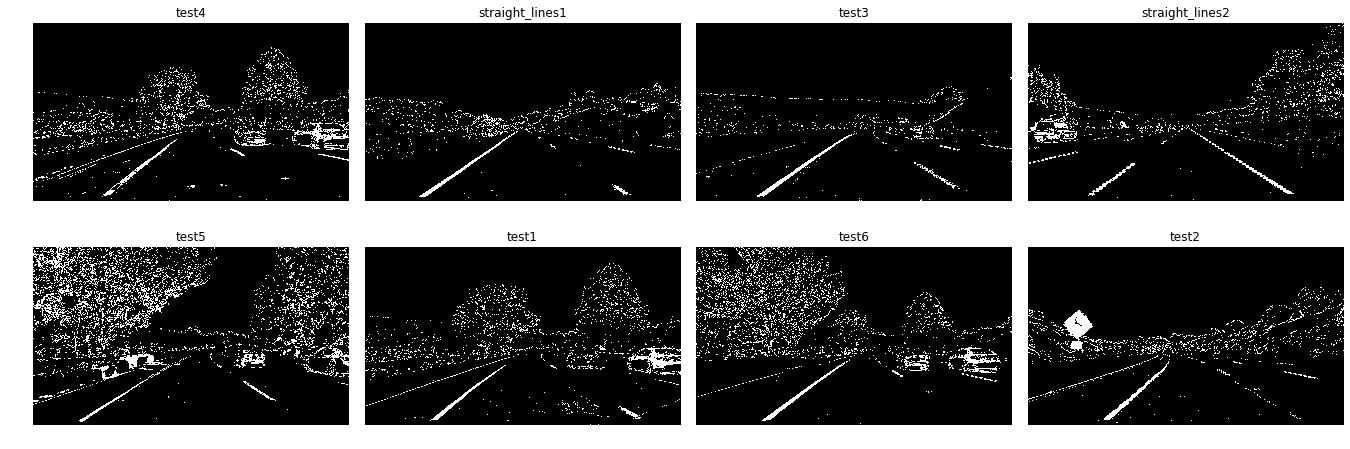

In [19]:
test_binary_image()

## Step 3 Source points finding for perspective transformation

In order to get rid of other selected pixels in the binary scene and better calculate curvatures of the roads, I need to do perspective transformation into a "bird eye" view. First, source points should be found in the source images. 

Ideally, I need to select four source points in a trapezoidal shape which will present a rectangle after perspective transformation. I seek to automatically determine those points. So I make use of line detection of last project and use hough transformation to determine a parameterized line representation of lanes and get the corresponding four points according to a predefined region masking.

In [21]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [22]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [23]:
def draw_lines(img, lines, color=[0, 0, 255], thickness=10, straight_line = False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    if not straight_line:

        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    else:

        left_points_x = []
        left_points_y = []
        
        right_points_x = []
        right_points_y = []
        
        min_y = 1000

        for line in lines:
        
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                
                if slope < 0:

                    left_points_x += [x1,x2]
                    left_points_y += [y1,y2]
                else:

                    right_points_x += [x1,x2]
                    right_points_y += [y1,y2]
                    
                
                if min(y1,y2) < min_y:
                    min_y = min(y1,y2)
        
        ransac_left = linear_model.RANSACRegressor()
        ransac_right = linear_model.RANSACRegressor()
        
        ransac_left.fit(np.asarray(left_points_y)[:,np.newaxis], np.asarray(left_points_x)[:,np.newaxis])
        ransac_right.fit(np.asarray(right_points_y)[:,np.newaxis], np.asarray(right_points_x)[:,np.newaxis])
        
        predicted_points_left = ransac_left.predict(np.asarray([img.shape[0], min_y])[:,np.newaxis])
        predicted_points_right = ransac_right.predict(np.asarray([img.shape[0], min_y])[:,np.newaxis])
        
        cv2.line(img, (int(predicted_points_left[0]), img.shape[0]), (int(predicted_points_left[1]), min_y), color, thickness)
        cv2.line(img, (int(predicted_points_right[0]), img.shape[0]), (int(predicted_points_right[1]), min_y), color, thickness)


In [24]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, straight_line = False, draw_line = True):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    if draw_line:
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        draw_lines(line_img, lines, straight_line=straight_line)
        return line_img
    else:
        return lines

In [26]:
def test_automatic_source_points():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    rho = 2
    theta = np.pi/180
    threshold = 100
    min_line_len = 50
    max_line_gap = 100

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./test_images')):

        img_path = os.path.join('./test_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion

        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding

        grad_x_binary_map = abs_sobel_thresh(img, thresh=(20,100))
        s_binary_map, _ = hls_thres(img, thresh=(170,255))

        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,np.pi/2))

        color_binary = np.dstack(( dir_binary_map, grad_x_binary_map, s_binary_map)) * 255

        combined_binary = np.zeros_like(s_binary_map)
        combined_binary[(s_binary_map == 1) | (grad_x_binary_map == 1) & (dir_binary_map == 1)] = 1
        
        vertices = np.asarray([[(150,img.shape[0]),(600,450),(730,450),(img.shape[1],img.shape[0])]])

        masked_img = region_of_interest(combined_binary, vertices)

        line_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap, straight_line=True)

        added_line_img = weighted_img(line_img, img)

        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(added_line_img[...,::-1])
        # ax.imshow(combined_binary, cmap='gray')
        ax.set_title(img_nm.split('.')[0])
        # plt.tight_layout()
    
#     plt.savefig('./output_images/src_points_test_image.png')
    plt.show()


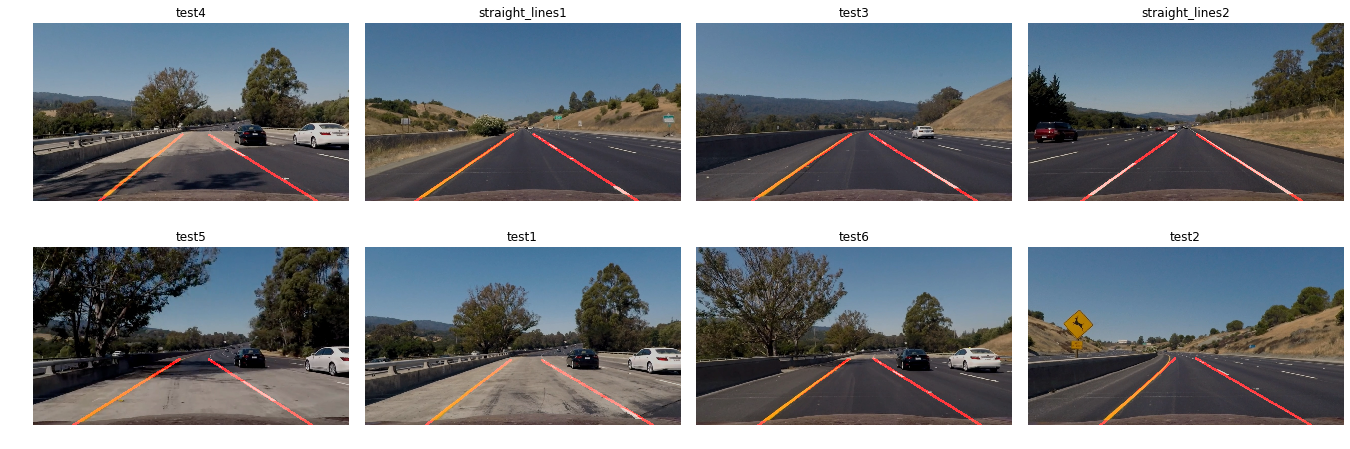

In [27]:
test_automatic_source_points()

## Step 4 Perspective transformation

Destination points can be easily selected, as long as they represent a rectangle. Then, I make use of [OpenCV code](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html?highlight=perspective%20transform) to do the transformation. 

I set the destination points as `np.float32([[300, img.shape[0]], [offset, 0], [img.shape[1]-300, 0], [img.shape[1]-300, img.shape[0]]])
`

In [28]:
def src_points_perspective(img, lines, top_y):
    """source points determination based on detected hough lines
    Input:
        img: input image
        lines: lines created by hough transformation
        top_y: y coordinate of top point
    """

    
    left_points_x = []
    left_points_y = []
    
    right_points_x = []
    right_points_y = []
    
    # min_y = 1000

    for line in lines:
    
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            if slope < 0:

                left_points_x += [x1,x2]
                left_points_y += [y1,y2]
            else:

                right_points_x += [x1,x2]
                right_points_y += [y1,y2]
                
            
            # if min(y1,y2) < min_y:
            #     min_y = min(y1,y2)
    
    ransac_left = linear_model.RANSACRegressor()
    ransac_right = linear_model.RANSACRegressor()
    
    ransac_left.fit(np.asarray(left_points_y)[:,np.newaxis], np.asarray(left_points_x)[:,np.newaxis])
    ransac_right.fit(np.asarray(right_points_y)[:,np.newaxis], np.asarray(right_points_x)[:,np.newaxis])
    
    predicted_points_left = ransac_left.predict(np.asarray([img.shape[0], top_y])[:,np.newaxis])
    predicted_points_right = ransac_right.predict(np.asarray([img.shape[0], top_y])[:,np.newaxis])
    
    # cv2.line(img, (int(predicted_points_left[0]), img.shape[0]), (int(predicted_points_left[1]), min_y), color, thickness)
    # cv2.line(img, (int(predicted_points_right[0]), img.shape[0]), (int(predicted_points_right[1]), min_y), color, thickness)

    return {'left_bottom': np.float32([int(predicted_points_left[0]), img.shape[0]]),
            'left_top': np.float32([int(predicted_points_left[1]), top_y]),
            'right_bottom': np.float32([int(predicted_points_right[0]), img.shape[0]]),
            'right_top': np.float32([int(predicted_points_right[1]), top_y])}


In [36]:
def perspective_transform(src, dst, img, gray_shape, draw_line=False):
    """ perspective transform, giving source and destination points """
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, gray_shape[::-1])
    
    if draw_line:
        cv2.line(warped, tuple(dst[0].astype(int)), tuple(dst[1].astype(int)), color=[0,0,255], thickness=5)
        cv2.line(warped, tuple(dst[2].astype(int)), tuple(dst[3].astype(int)), color=[0,0,255], thickness=5)
        
    return warped, M

In [37]:
def test_perspective_trans():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    rho = 2
    theta = np.pi/180
    threshold = 100
    min_line_len = 50
    max_line_gap = 100

    offset = 300
    top_y = 450

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 

    for idx, img_nm in enumerate(os.listdir('./test_images')):
        img_path = os.path.join('./test_images', img_nm)

        img = cv2.imread(img_path)

        img = cv2.undistort(img, mtx, dist, None, mtx)

        grad_x_binary_map = abs_sobel_thresh(img, thresh=(20,100))
        s_binary_map, _ = hls_thres(img, thresh=(170,255))

        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,np.pi/2))

        color_binary = np.dstack(( dir_binary_map, grad_x_binary_map, s_binary_map)) * 255

        combined_binary = np.zeros_like(s_binary_map)
        combined_binary[(s_binary_map == 1) | (grad_x_binary_map == 1) & (dir_binary_map == 1)] = 1

        vertices = np.asarray([[(150,img.shape[0]),(600,450),(750,450),(img.shape[1],img.shape[0])]])

        masked_img = region_of_interest(combined_binary, vertices)

        hough_lines_ = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap, straight_line=True, draw_line=False)

        src_points = src_points_perspective(img, hough_lines_, top_y)

        dst_points = np.float32([[offset, img.shape[0]], [offset, 0], [img.shape[1]-offset, 0], [img.shape[1]-offset, img.shape[0]]])

        warped_img, _ = perspective_transform(np.float32([src_points['left_bottom'], 
                                                       src_points['left_top'],
                                                       src_points['right_top'],
                                                       src_points['right_bottom']]), 
                                           dst_points, img, img.shape[:2], draw_line=True)

        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(warped_img[...,::-1], cmap='gray')
        ax.set_title(img_nm.split('.')[0])
#     plt.savefig('./output_images/perspective_test_image.png')
    plt.show()

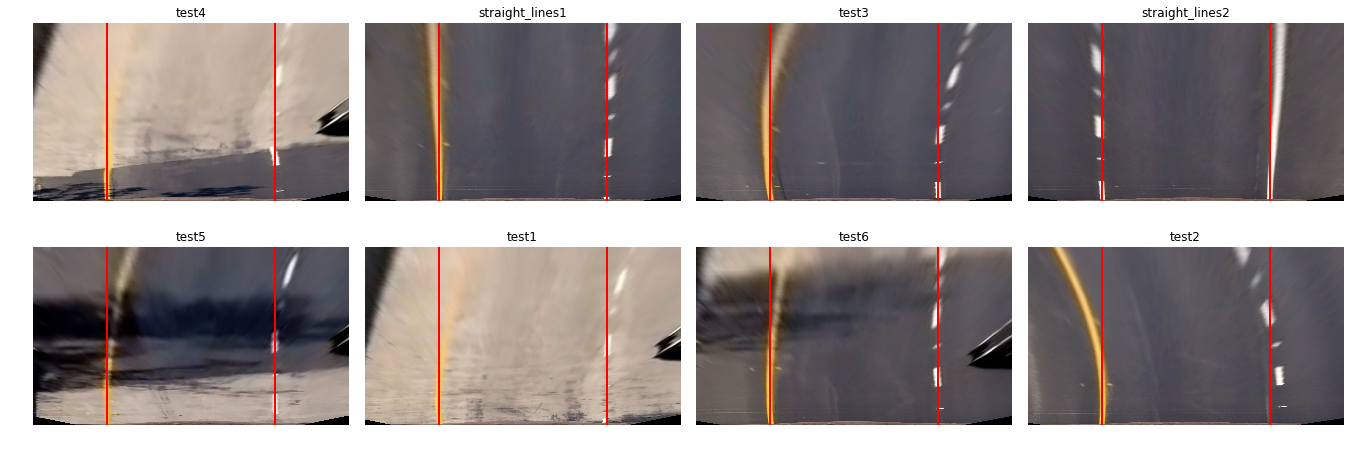

In [38]:
test_perspective_trans()

## Step 5 Detection of roads in transformed binary images

 Accordingly, I can also obtain binary images in the birdeye view. In order to determine the road regions, I make use of the sliding window method inroduced in udacity class. For representing a curved lane, the detected road pixels can be represented by a second order polynomial. The details are described as follow:

* Calculating the historgram by summing the binary values in the bottom half binary image along the y direction.
* Find the peak positions on the left and right, which represent the starting points of roads.
* Within a certain area of sliding window, extracting the coordinates of all active points (binary value = 1) and append to the road coordinate lists. Recalculating the current middle point according to those coordinates inside the sliding window, if the number of active points is larger than a threshold, or stay unchanged.
* After the collection of all sliding windows, a second order polynomial can be fitted by the `(x,y)` coordinates of road points.

In [39]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = int(leftx_current - margin)  # Update this
        win_xleft_high = int(leftx_current + margin)  # Update this
        win_xright_low = int(rightx_current - margin)  # Update this
        win_xright_high = int(rightx_current + margin)  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        leftx_p = leftx_current
        rightx_p = rightx_current

        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds])

        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds])

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [40]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###

    left_fit = np.polyfit(lefty, leftx, deg=2)
    right_fit = np.polyfit(righty, rightx, deg=2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    left_pts = np.array(list(zip(left_fitx, ploty)), np.int32)
    left_pts = left_pts.reshape((-1,1,2))
    right_pts = np.array(list(zip(right_fitx, ploty)), np.int32)
    right_pts = right_pts.reshape((-1,1,2))

    cv2.polylines(out_img,[left_pts],False,(0,255,255),10)
    cv2.polylines(out_img,[right_pts],False,(0,255,255),10)

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty


In [43]:
def test_poly_fitting():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    rho = 2
    theta = np.pi/180
    threshold = 100
    min_line_len = 50
    max_line_gap = 100

    offset = 300
    ym_per_pix = 30/720
    xm_per_pix = 3.7/680
    top_y = 450

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 

    for idx, img_nm in enumerate(os.listdir('./test_images')):
        img_path = os.path.join('./test_images', img_nm)

        img = cv2.imread(img_path)

        img = cv2.undistort(img, mtx, dist, None, mtx)

        grad_x_binary_map = abs_sobel_thresh(img, thresh=(20,100))
        s_binary_map, _ = hls_thres(img, thresh=(170,255))

        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,np.pi/2))

        color_binary = np.dstack(( dir_binary_map, grad_x_binary_map, s_binary_map)) * 255

        combined_binary = np.zeros_like(s_binary_map)
        combined_binary[(s_binary_map == 1) | (grad_x_binary_map == 1) & (dir_binary_map == 1)] = 1

        vertices = np.asarray([[(150,img.shape[0]),(600,450),(750,450),(img.shape[1],img.shape[0])]])

        masked_img = region_of_interest(combined_binary, vertices)

        hough_lines_ = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap, straight_line=True, draw_line=False)

        src_points = src_points_perspective(img, hough_lines_, top_y)

        dst_points = np.float32([[offset, img.shape[0]], [offset, 0], [img.shape[1]-offset, 0], [img.shape[1]-offset, img.shape[0]]])

        warped_img,_ = perspective_transform(np.float32([src_points['left_bottom'], 
                                                       src_points['left_top'],
                                                       src_points['right_top'],
                                                       src_points['right_bottom']]), 
                                           dst_points, combined_binary, img.shape[:2])
        
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, _, _, _, _ = fit_polynomial(warped_img)


        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(out_img[...,::-1])
        ax.set_title(img_nm.split('.')[0])

#     plt.savefig('./output_images/final_test_image.png')
    plt.show()

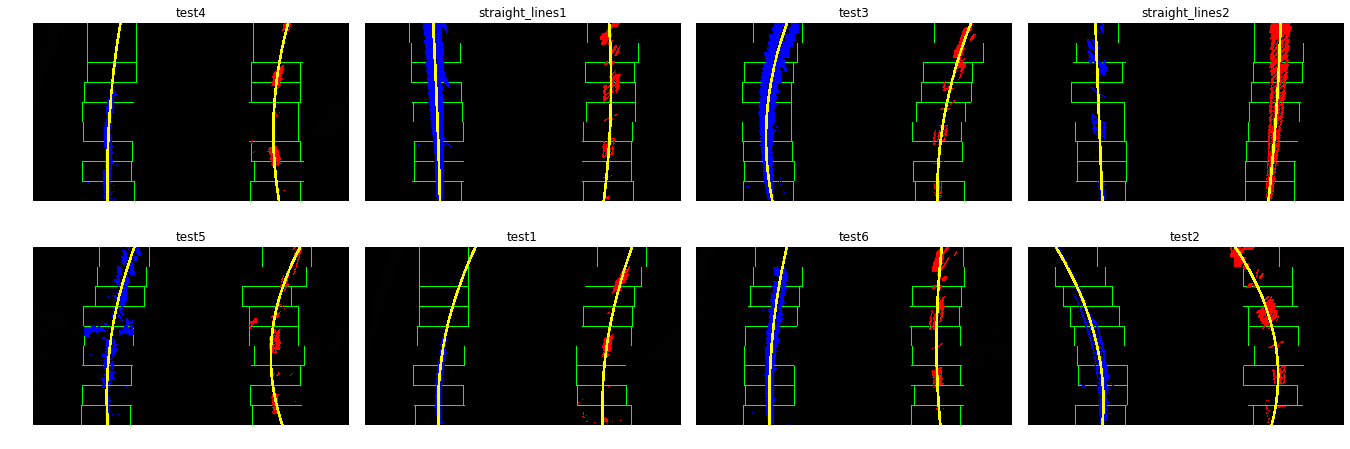

In [44]:
test_poly_fitting()

## Step 6 Curvature calculation

 At last, curvature of roads can be easily calculated by mathmatical manipulation. Also, the position of vehicle with respect to lane can be also obtained. In details,

* Take left lane for example, the curvature can be calculated by:
    `left_curverad = (1 + (2 * left_fit_cr[0] * (y_eval*ym_per_pix) + left_fit_cr[1])**2)**(3/2)/(2*abs(left_fit_cr[0]))`, where `left_fit_cr` are the coefficients of second order polynomial and `ym_per_pix` is how many meters are one pixel represent in y direction. It can be set as `30/720`.
* Vehicle offset can be calculated by `car_offset = ((x_left + x_right)/2 - width/2) * xm_per_pix`, where `xm_per_pix` is `3.7/700`, `width` is the width of the whole image.

In [45]:
def measure_curvature_real(ym_per_pix, left_fit_cr, right_fit_cr, y_eval):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    # ym_per_pix = 30/720 # meters per pixel in y dimension
    # xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    # ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    # y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2 * left_fit_cr[0] * (y_eval*ym_per_pix) + left_fit_cr[1])**2)**(3/2)/(2*abs(left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = (1 + (2 * right_fit_cr[0] * (y_eval*ym_per_pix) + right_fit_cr[1])**2)**(3/2)/(2*abs(right_fit_cr[0]))  ## Implement the calculation of the right line here
    
    averaged_curverad = (left_curverad + right_curverad)/2

    return averaged_curverad

In [46]:
def drawing_lane_line_area(warped_size, left_fitx, right_fitx, ploty, image, Minv):

    # Create an image to draw the lines on
    warp_zero = np.zeros(warped_size).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result

In [47]:
def test_curvature_position_test_images():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    rho = 2
    theta = np.pi/180
    threshold = 100
    min_line_len = 50
    max_line_gap = 100

    offset = 300
    ym_per_pix = 30/720
    xm_per_pix = 3.7/680
    top_y = 450

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 

    for idx, img_nm in enumerate(os.listdir('./test_images')):
        img_path = os.path.join('./test_images', img_nm)

        img = cv2.imread(img_path)

        img = cv2.undistort(img, mtx, dist, None, mtx)

        grad_x_binary_map = abs_sobel_thresh(img, thresh=(20,100))
        s_binary_map, _ = hls_thres(img, thresh=(170,255))

        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,np.pi/2))

        color_binary = np.dstack(( dir_binary_map, grad_x_binary_map, s_binary_map)) * 255

        combined_binary = np.zeros_like(s_binary_map)
        combined_binary[(s_binary_map == 1) | (grad_x_binary_map == 1) & (dir_binary_map == 1)] = 1

        vertices = np.asarray([[(150,img.shape[0]),(600,450),(750,450),(img.shape[1],img.shape[0])]])

        masked_img = region_of_interest(combined_binary, vertices)

        hough_lines_ = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap, straight_line=True, draw_line=False)

        src_points = src_points_perspective(img, hough_lines_, top_y)

        dst_points = np.float32([[offset, img.shape[0]], [offset, 0], [img.shape[1]-offset, 0], [img.shape[1]-offset, img.shape[0]]])

        warped_img,_ = perspective_transform(np.float32([src_points['left_bottom'], 
                                                       src_points['left_top'],
                                                       src_points['right_top'],
                                                       src_points['right_bottom']]), 
                                           dst_points, combined_binary, img.shape[:2])
        
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, _, _, _, _ = fit_polynomial(warped_img)

        curvature = measure_curvature_real(ym_per_pix, left_fit, right_fit, img.shape[0])

        Minv = cv2.getPerspectiveTransform(dst_points, np.float32([src_points['left_bottom'], 
                                                       src_points['left_top'],
                                                       src_points['right_top'],
                                                       src_points['right_bottom']]))

        out_source_img = drawing_lane_line_area(out_img.shape[:2], left_fitx, right_fitx, ploty, img, Minv)

        car_offset = ((src_points['right_bottom'][0] + src_points['left_bottom'][0])/2 - 640) * xm_per_pix

        if car_offset >= 0:
            text = 'vehicle is {0:.2f}(m) right of center'.format(abs(car_offset))
        else:
            text = 'vehicle is {0:.2f}(m) left of center'.format(abs(car_offset))

        cv2.putText(out_source_img, 'Radius of curvature: {}(m)'.format(int(curvature)),
                    (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5)

        cv2.putText(out_source_img, text,
                    (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5)

        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(out_source_img[...,::-1])
        ax.set_title(img_nm.split('.')[0])

#     plt.savefig('./output_images/final_test_image.png')
    plt.show()


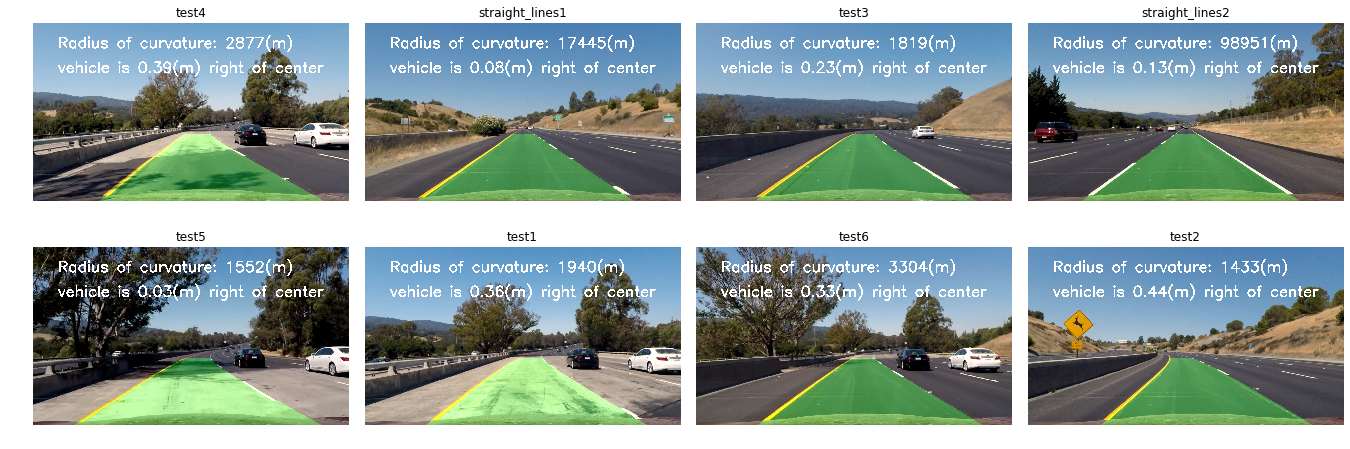

In [48]:
test_curvature_position_test_images()

## Modification for videos

At first, I would like to test the proposed pipeline on the project and challenge videos, but it does not work on challenge video. I rethink about the shortcomings and improve the method further. 

For the challenge video, the vehicle went under a brodge, where the roads are very dark. It makes the above thresholding method may not extract road areas. Also, since the frequent variation of lightness and color of roads in the challenge video, the source point positions determined by the above automatic method are not consistent in video time-series, since I make use of Hough transform to detect lines first. In that case, the parameters of fitted polynomial also vary accordingly and it makes the fitted line jumping a lot in the challenge video.


To this end, I modify two parts of the above pipeline: 

* Investigate gradient and color thresholding again for the challenge video.
* I resort to a pre-defined fixed source points rather than automatic detection.

### Modification 1 Thresholding

By utilizing S channel on the converted HSL image with the threshold `(50,255)`, left yellow line can be extracted in challenge images. 


In [52]:
def hls_thres_L(img, thresh=(0, 255)):
    """ thresholding based on L channel value of HLS image 
    Input:
        img: BGR image read by cv2
        thresh: low and upper thresholds for values of L channel
    Output:
        binary_output: binary map of preserved values in-between the thresholds
    """
    img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    L_channel = img_HLS[...,-2]
    binary_output = np.zeros_like(L_channel)
    binary_output[(L_channel>thresh[0])&(L_channel<=thresh[1])] = 1
    
    return binary_output, L_channel

In [55]:
def test_S_binary():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./challenge_images')):

        img_path = os.path.join('./challenge_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding
        grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
        s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
        l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))

        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(s_binary_map, cmap='gray')
        ax.set_title(img_nm)

        # ax.imshow(added_line_img[...,::-1])
        
#     plt.savefig('./output_images/final_bin_challenge_images.png')
    plt.show()

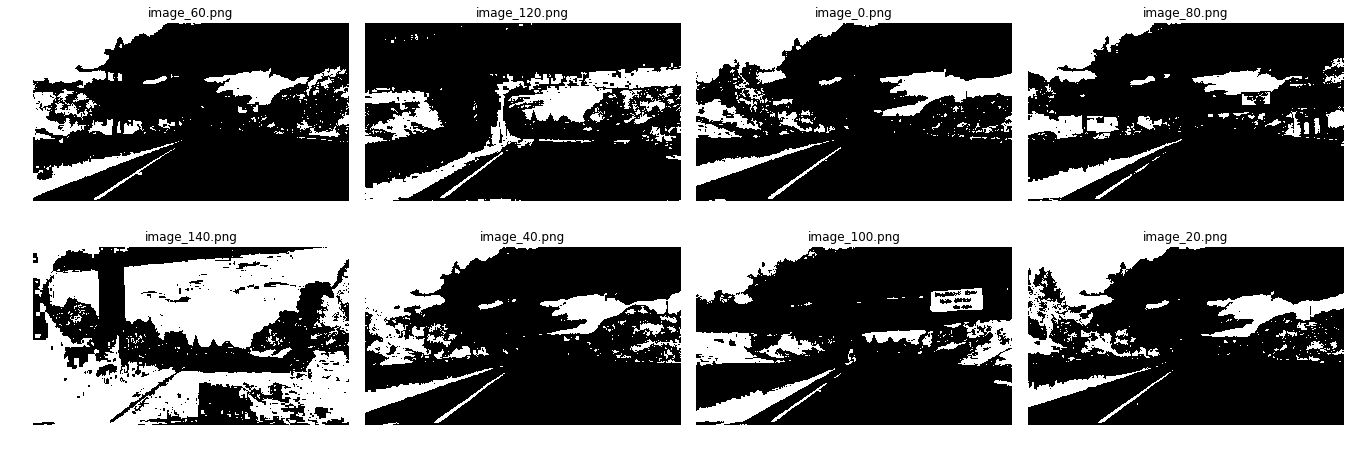

In [56]:
test_S_binary()

By thresholding on L channel on the converted HSL image with the threshold `(160,255)`, white lanes can also be extracted.


In [57]:
def test_L_binary():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./challenge_images')):

        img_path = os.path.join('./challenge_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding
        grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
        s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
        l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))

        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(l_binary_map, cmap='gray')
        ax.set_title(img_nm)

        # ax.imshow(added_line_img[...,::-1])
        
#     plt.savefig('./output_images/final_bin_challenge_images.png')
    plt.show()

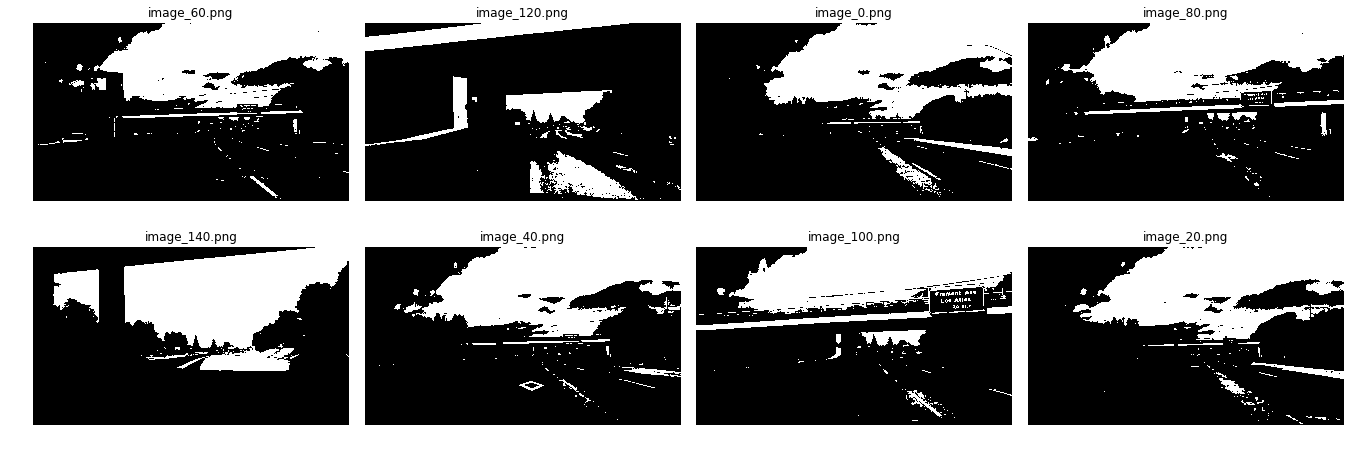

In [58]:
test_L_binary()

By combining those binary maps based on `|` operation, I can select both yellow and white lines and I term it as `combined_sl`


In [59]:
def test_SL_binary():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./challenge_images')):

        img_path = os.path.join('./challenge_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding
        grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
        s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
        l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))
        
        combined_binary = np.zeros_like(s_binary_map)
        # combined_binary[((b_binary == 1) | (l_binary_map == 1)) & (dir_binary_map == 1) & (grad_x_binary_map==1)] = 1
        combined_binary[((l_binary_map==1) | (s_binary_map==1)) ] = 1
        
        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(combined_binary, cmap='gray')
        ax.set_title(img_nm)

        # ax.imshow(added_line_img[...,::-1])
        
#     plt.savefig('./output_images/final_bin_challenge_images.png')
    plt.show()

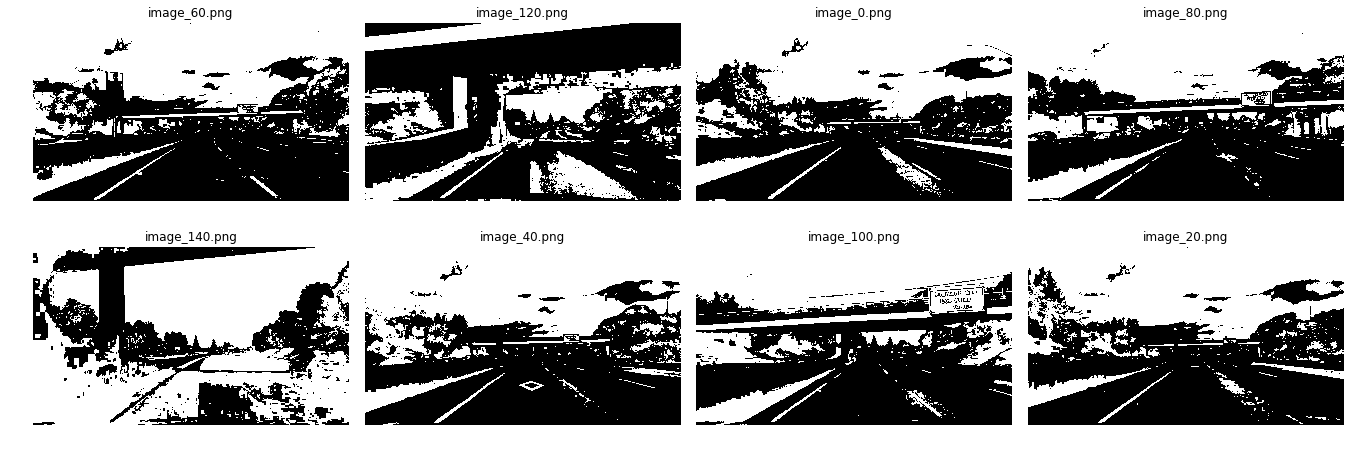

In [60]:
test_SL_binary()

However, there are much more information around the roads should be deleted. I then make use of gradient information. 

First, by thresholding on gradient values along x direction with the threshold of `(5,100)`, vertical structures can be largely remained.


In [61]:
def test_GradX_binary():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./challenge_images')):

        img_path = os.path.join('./challenge_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding
        grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
        s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
        l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))
        
        combined_binary = np.zeros_like(s_binary_map)
        # combined_binary[((b_binary == 1) | (l_binary_map == 1)) & (dir_binary_map == 1) & (grad_x_binary_map==1)] = 1
        combined_binary[((l_binary_map==1) | (s_binary_map==1)) ] = 1
        
        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(grad_x_binary_map, cmap='gray')
        ax.set_title(img_nm)

        # ax.imshow(added_line_img[...,::-1])
        
#     plt.savefig('./output_images/final_bin_challenge_images.png')
    plt.show()

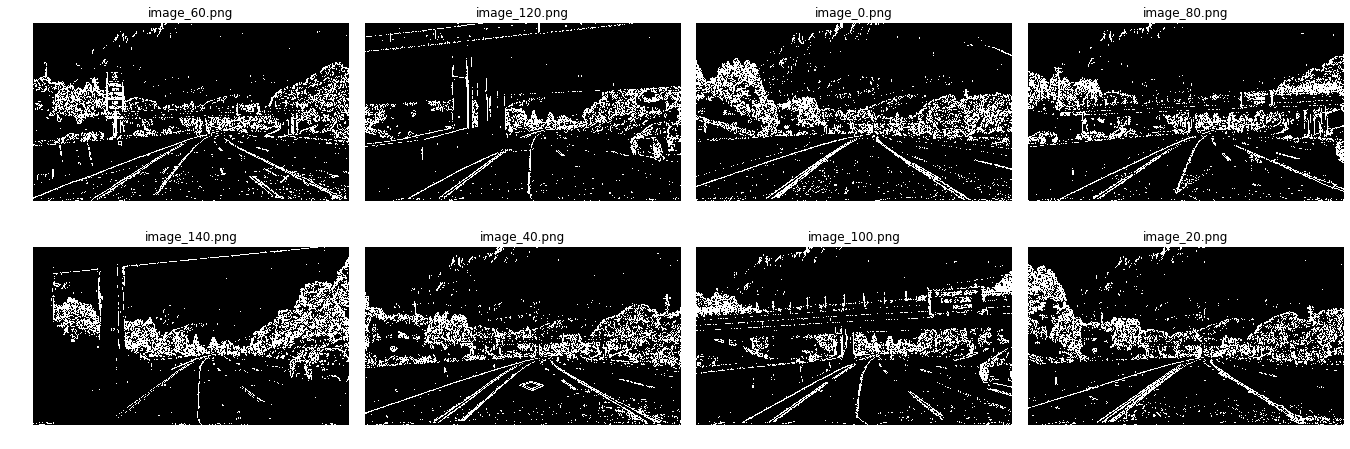

In [62]:
test_GradX_binary()

In [63]:
def test_GradAngle_binary():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./challenge_images')):

        img_path = os.path.join('./challenge_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding
        grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
        s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
        l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))
        
        combined_binary = np.zeros_like(s_binary_map)
        # combined_binary[((b_binary == 1) | (l_binary_map == 1)) & (dir_binary_map == 1) & (grad_x_binary_map==1)] = 1
        combined_binary[((l_binary_map==1) | (s_binary_map==1)) ] = 1
        
        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(dir_binary_map, cmap='gray')
        ax.set_title(img_nm)

        # ax.imshow(added_line_img[...,::-1])
        
#     plt.savefig('./output_images/final_bin_challenge_images.png')
    plt.show()

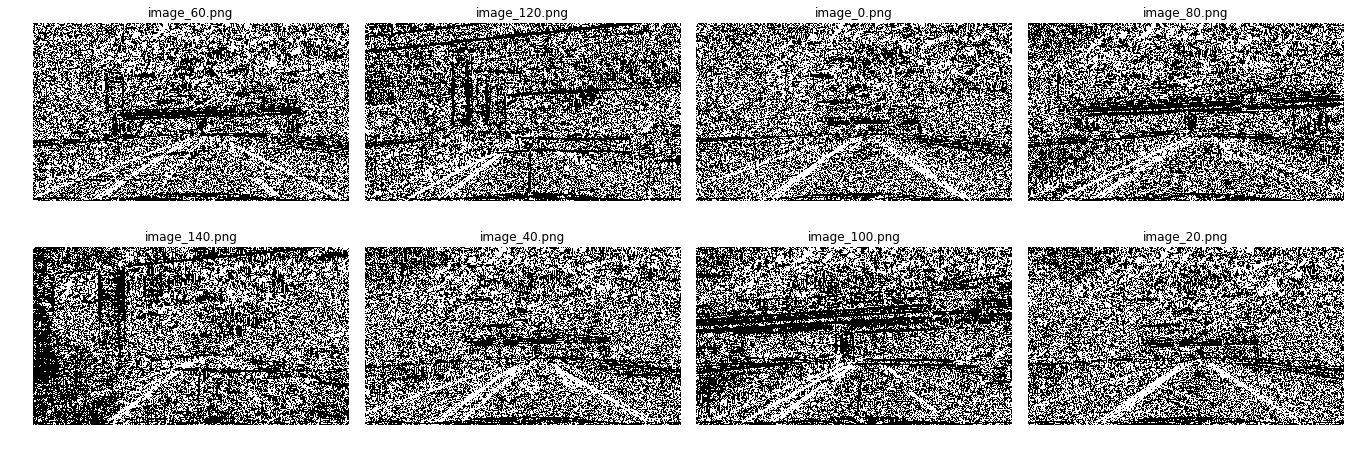

In [64]:
test_GradAngle_binary()

We can see that most road parts are very bright and almost verticle line in the results of gradient image is thresholded out (image_100, image_140 in the above result).

By combining these two gradient information by `&` operation, I get and term it as `combined_dir_grad_x`

In [65]:
def test_GradX_GradAngle_binary():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./challenge_images')):

        img_path = os.path.join('./challenge_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding
        grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
        s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
        l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))
        
        combined_binary = np.zeros_like(s_binary_map)
        # combined_binary[((b_binary == 1) | (l_binary_map == 1)) & (dir_binary_map == 1) & (grad_x_binary_map==1)] = 1
        combined_binary[((dir_binary_map == 1) & (grad_x_binary_map==1)) ] = 1
        
        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(combined_binary, cmap='gray')
        ax.set_title(img_nm)

        # ax.imshow(added_line_img[...,::-1])
        
#     plt.savefig('./output_images/final_bin_challenge_images.png')
    plt.show()

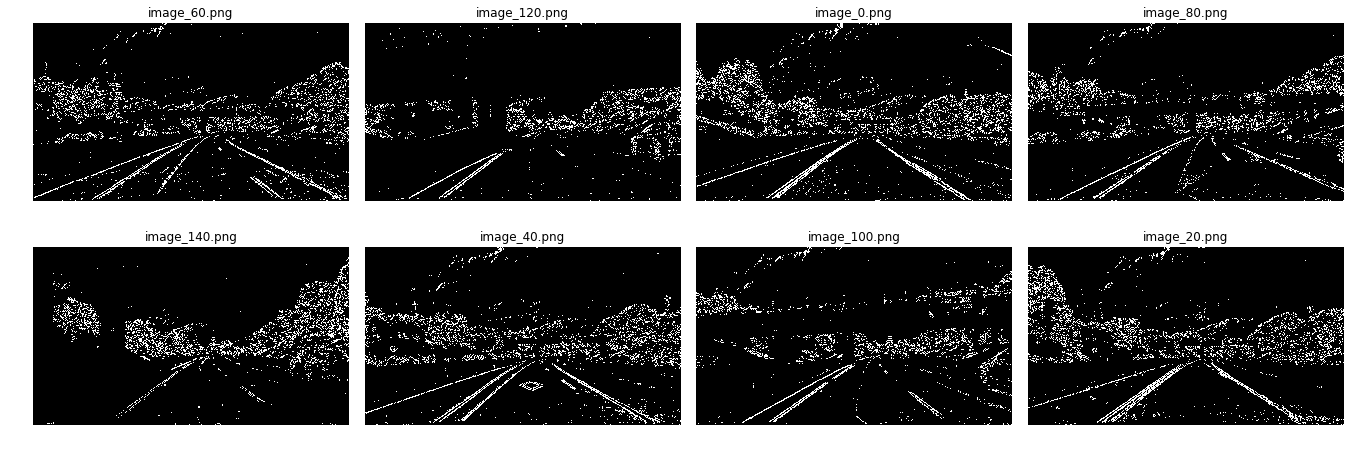

In [66]:
test_GradX_GradAngle_binary()


At the end, I fuse the information of the created two combined image, i.e. `combined_dir_grad_x` and `combined_sl` by using `&`, I get


In [67]:
def test_final_challenge_binary():
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    # img_path = './test_images/test2.jpg'
    # img_path = './test_images/straight_lines2.jpg'

    plt.figure(figsize = (20,7))
    gs1 = gridspec.GridSpec(2, 4)
    gs1.update(left=0.02, right=0.93, top=0.92, bottom=0.03, hspace=0., wspace=0.05) # set the spacing between axes. 


    for idx, img_nm in enumerate(os.listdir('./challenge_images')):

        img_path = os.path.join('./challenge_images', img_nm)


        img = cv2.imread(img_path)

        #### image undistortion
        
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # cv2.imshow('img', dst)
        # cv2.waitKey(0)

        #### combine gradients and color thresholding
        grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
        s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
        l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
        dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))
        
        combined_binary = np.zeros_like(s_binary_map)
        combined_binary[((s_binary_map == 1) | (l_binary_map == 1)) & ((dir_binary_map==1) & (grad_x_binary_map==1))] = 1
        
        ax = plt.subplot(gs1[idx])
        ax.set_axis_off()
        ax.imshow(combined_binary, cmap='gray')
        ax.set_title(img_nm)

        # ax.imshow(added_line_img[...,::-1])
        
#     plt.savefig('./output_images/final_bin_challenge_images.png')
    plt.show()

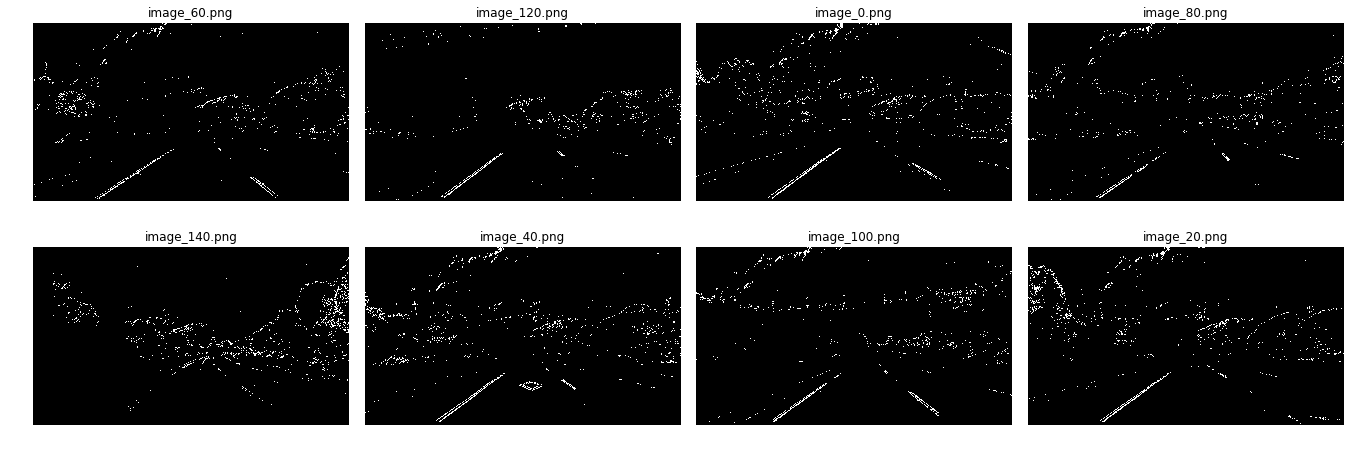

In [68]:
test_final_challenge_binary()


As we can see, pixels of left and right lanes can be dominated, while the other parts of the images are suppressed. 


However, we still see that there are almost no detected roads in **image_140**, since the vehicle is under the bridge. I resort to use time-series information for generating the lane lines in this frame. 


### Modification 2 Fixed source points

The source points and destination points I used for project video and challenge video are:

| Source        | Destination   |  
|:-------------:|:-------------:| 
| 520, 450      | 0, 0          | 
| 730, 450      | 1280, 0       |
| 1127, 720     | 1250, 720     |
| 1250, 720     | 40, 720       |


| Source        | Destination   |  
|:-------------:|:-------------:| 
| 520, 482      | 0, 0          | 
| 800, 482      | 1280, 0       |
| 1250, 720     | 1250, 720     |
| 40, 720       | 40, 720       |


I think these two steps are two main steps for adaptation the method on the challenge video. 

### Tracking the time-series


Information from single frame cannot be sufficient for creating a stable lane line detection, especially for areas covered by shadow. Making use of time-series information can be helpful to obtain more robust result. 

In the experiment, I mainly track three variables:
* bottom x coordinate of line.
* top x coordinate of line.
* fitted polynomial coefficients of line.

All the current information is created by the averaged values of those variables on e.g. `N=15` frames.

In order to improve the robustness, average operation can be replaced by [trim_mean](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trim_mean.html).


In [69]:
# Define a class to receive the characteristics of each line detection
class Line():
    """ line class for lane detection 
    wraped_shape: shape of input image
    N: number of frames to track
    ym_per_pix: how many meters one pixel represent along y direction
    """
    def __init__(self, wraped_shape, N, ym_per_pix, xm_per_pix):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_x_bottom = deque(maxlen=N)
        self.recent_x_top = deque(maxlen=N)
        self.best_x_bottom = None
        self.best_x_top = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        self.recent_fit = deque(maxlen=N)
        #polynomial coefficients for the most recent fit
        # self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = np.linspace(0, wraped_shape[0]-1, wraped_shape[0])  

        self.curv_y_eval = wraped_shape[0]
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix

    def update_recent_fit(self, fit):
        """ update the polynomial coefficients"""
        self.recent_fit.append(fit)

    def update_recent_x_bottom(self, x):
        """ update the bottom x coordinate """
        self.recent_x_bottom.append(x)

    def update_recent_x_top(self, x):
        """ update the top x coordinate """
        self.recent_x_top.append(x)
    
    def calc_best_x_bottom(self):
        """ average the bottom x coordinate """
        x_points = np.asarray(list(self.recent_x_bottom))
        # self.best_x_bottom = np.mean(x_points)
        self.best_x_bottom = stats.trim_mean(x_points, proportiontocut=0.3)
    
    def calc_best_x_top(self):
        """ average the top x coordinate """
        x_points = np.asarray(list(self.recent_x_top))
        # self.best_x_top = np.mean(x_points)
        self.best_x_top = stats.trim_mean(x_points, proportiontocut=0.3)

    def calc_best_fit(self):
        """ average the polynomial coefficients """
        fits = np.concatenate(tuple(self.recent_fit), axis=1)
        # self.best_fit = np.mean(fits,axis=1)
        self.best_fit = stats.trim_mean(fits, proportiontocut=0.3, axis=1)

    def calc_radius_of_curvature(self):
        """ calculate the curvature """
        # self.radius_of_curvature = (1 + (2 * self.best_fit[0] * (self.curv_y_eval*self.ym_per_pix) + self.best_fit[1])**2)**(3/2)/(2*abs(self.best_fit[0]))

        real_a = self.best_fit[0] * self.xm_per_pix/(self.ym_per_pix**2)
        real_b = self.best_fit[1] * self.xm_per_pix/self.ym_per_pix

        numerator = (1 + (2*real_a*(self.curv_y_eval*self.ym_per_pix)+real_b)**2)**1.5
        denominator = 2*abs(real_a)

        self.radius_of_curvature = numerator/denominator


    def calc_line_base_pos(self):
        """ update the current position of line """
        # self.line_base_pos = self.best_x_bottom
        self.line_base_pos = np.poly1d(self.best_fit)(self.curv_y_eval)

    def calc_allx(self):
        """ calculate the x according to the fitted polynomial  """
        self.allx = self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally + self.best_fit[2]

   


In [70]:
def find_lane_pixels_scratch(binary_warped, part = 'left'):
    """ modification of find lane pixels based on sliding window method for video processing 
    Input: 
    binary_warped: binary warped image
    part: left or right lane
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)

    if part == 'left':
        base = np.argmax(histogram[:midpoint])
    else:
        base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    if len(nonzero) == 0:
        print('no active pixels found in the warped binary img')
        return None
    else:
        # Current positions to be updated later for each window in nwindows
        x_current = base
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_x_low = int(x_current - margin)  # Update this
            win_x_high = int(x_current + margin)  # Update this
            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_inds = ((nonzerox >= win_x_low) & (nonzerox < win_x_high) & 
            (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            # x_p = x_current
            if len(good_inds) > minpix:
                x_current = np.mean(nonzerox[good_inds])
        
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
        
        if lane_inds.size == 0:
            print('no active points found in the interest areas')
            return None
        else:
            # Extract left and right line pixel positions
            x = nonzerox[lane_inds]
            y = nonzeroy[lane_inds] 

            return (x, y)

delte the above-defined fit_polynomial method 

In [71]:
del fit_polynomial

In [72]:
def fit_polynomial(binary_warped, line, part = 'left'):
    """ fit polynomial method for video processing
    Input:
        binary_warped: warped image
        line: left lane or right lane object
        part: left lane or right lane
        """
    
    # Find our lane pixels first
    # leftx, lefty, rightx, righty, out_img = find_lane_pixels_scratch(binary_warped, part = 'left')
    
    points = find_lane_pixels_scratch(binary_warped, part = part)
    
    ### check whether the sliding window method find the lane
    if points is not None:
        x, y = points

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        fit = np.polyfit(y, x, deg=2)
        x_bottom = np.poly1d(fit)(binary_warped.shape[0])
        x_top = np.poly1d(fit)(0) 

        line.detected = True
        line.update_recent_fit(fit[:,np.newaxis])

        line.update_recent_x_bottom(x_bottom)
        line.update_recent_x_top(x_top)
        
        line.calc_best_fit()
        line.calc_best_x_bottom()
        line.calc_best_x_top()
        line.calc_allx()
        line.calc_line_base_pos()
        line.calc_radius_of_curvature()

    else:
        line.detected = False

In [73]:
def search_around_poly(binary_warped, margin, line, part='left'):
    """ modified search around the exist polynomial fitted line for video processing
    Input:
        binary_warped: input binary warped image
        margin: designed margin area to search
        line: left or right lane line object
        part: left or right lane
        """
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    # margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if len(nonzero) == 0:
        print('no active pixels found in the warped binary img')
        line.detected = False
        # return None
    else:
        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        lane_inds = ((nonzerox >= (np.poly1d(line.best_fit)(nonzeroy) - margin)) & (nonzerox < (np.poly1d(line.best_fit)(nonzeroy) + margin)))

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        if len(lane_inds) == 0:
            print('previous polynomial fit cannot help find the current active points')
            print('create the polinomial from scratch again')
            fit_polynomial(binary_warped, line, part = 'left')
            if line.detected == False:
                print('cannot find polinomial from scratch, use recorded parameter to draw')
                # return None
        else:
            fit = np.polyfit(y, x, deg=2)
            x_bottom = np.poly1d(fit)(binary_warped.shape[0])
            x_top = np.poly1d(fit)(0)

            line.detected = True
            line.update_recent_fit(fit[:,np.newaxis])

            line.update_recent_x_bottom(x_bottom)
            line.update_recent_x_top(x_top)
        
            line.calc_best_fit()
            line.calc_best_x_bottom()
            line.calc_best_x_top()
            line.calc_allx()
            line.calc_line_base_pos()
            line.calc_radius_of_curvature()

            # return 1


In [74]:
del drawing_lane_line_area

In [75]:
def drawing_lane_line_area(warped_size, left_lane, right_lane, image, Minv):
    """ modified function for video processing """
    # Create an image to draw the lines on
    warp_zero = np.zeros(warped_size).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_lane.allx, left_lane.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.allx, right_lane.ally])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result

### Creation output for project video

In [81]:
def create_output_4_proj_video():
#     video_pth = './challenge_video.mp4'
    video_pth = './project_video.mp4'
    # video_pth = './harder_challenge_video.mp4'
    
    

    video_capture = cv2.VideoCapture(video_pth)

    ret, frame = video_capture.read()
    # [h, w] = frame.shape[:2]
    # print(frame.shape)
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    #### challenge video
#     src = np.float32([[520, 482],[800, 482],
#                       [1250, 720],[40, 720]])

    #### project video
    src = np.float32([[520, 450],[730, 450],
                      [1250, 720],[40, 720]])

    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    frame_num = 0
    margin = 60

    left_lane = Line(frame.shape, N=15, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix)
    right_lane = Line(frame.shape, N=15, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix)

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('./output_images/project_output.mp4',fourcc, 20.0, (frame.shape[1],frame.shape[0]))


    while True:

        print(frame_num)

        ret, frame = video_capture.read()

        if ret==True:
            img = cv2.undistort(frame, mtx, dist, None, mtx)

            grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
            s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
            l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
            dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))

            color_binary = np.dstack(( dir_binary_map, grad_x_binary_map, s_binary_map)) * 255

            combined_binary = np.zeros_like(s_binary_map)

            combined_binary[((s_binary_map == 1) | (l_binary_map == 1)) & ((dir_binary_map==1) & (grad_x_binary_map==1))] = 1

            warped_img, _ = perspective_transform(src, dst, combined_binary, img.shape[:2], draw_line=False)
            
            # detect from scratch if lane line is not detected in last frame or frame mumber is 0
            
            if not left_lane.detected or (frame_num == 0):
                fit_polynomial(warped_img, left_lane, part='left')
            
            if not right_lane.detected or (frame_num == 0):
                fit_polynomial(warped_img, right_lane, part='right')
                
            # search around the margin area according to the fitted polynomial
            
            if left_lane.detected:
                search_around_poly(warped_img, margin, left_lane, part='left')
            if right_lane.detected:
                search_around_poly(warped_img, margin, right_lane, part='right')

            result = drawing_lane_line_area(img.shape[:2], left_lane, right_lane, img, Minv)

            vehicle_offset = ((left_lane.line_base_pos + right_lane.line_base_pos)/2 - (img.shape[1]/2)) * xm_per_pix
            
            if vehicle_offset >= 0:
                text = 'vehicle is {0:.2f}(m) right of center'.format(abs(vehicle_offset))
            else:
                text = 'vehicle is {0:.2f}(m) left of center'.format(abs(vehicle_offset))
            
            cv2.putText(result, 'Radius of curvature (left): {}(m)'.format(int(left_lane.radius_of_curvature)),
                        (100,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

            cv2.putText(result, 'Radius of curvature (right): {}(m)'.format(int(right_lane.radius_of_curvature)),
                        (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

            cv2.putText(result, text,
                        (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

#             cv2.imshow("video", result)

            # write the flipped frame
            out.write(result)

            frame_num += 1

#             k = cv2.waitKey(1) & 0xff

#             if k == ord('q') or k == 27:
#                 break
        else:
            break

    # Release everything if job is finished
    video_capture.release()
    out.release()
#     cv2.destroyAllWindows()

In [82]:
create_output_4_proj_video()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Creation output for challenge video

In [86]:
def create_output_4_challenge_video():
    video_pth = './challenge_video.mp4'
#     video_pth = './project_video.mp4'
    # video_pth = './harder_challenge_video.mp4'
    
    

    video_capture = cv2.VideoCapture(video_pth)

    ret, frame = video_capture.read()
    # [h, w] = frame.shape[:2]
    # print(frame.shape)
    img_dir = './camera_cal'
    _, mtx, dist, _, _ = camera_cal(img_dir, nx=9, ny=6)

    #### challenge video
    src = np.float32([[520, 482],[800, 482],
                      [1250, 720],[40, 720]])

    #### project video
#     src = np.float32([[520, 450],[730, 450],
#                       [1250, 720],[40, 720]])

    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    frame_num = 0
    margin = 60

    left_lane = Line(frame.shape, N=15, ym_per_pix=ym_per_pix,xm_per_pix=xm_per_pix)
    right_lane = Line(frame.shape, N=15, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix)

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('./output_images/challenge_output.mp4',fourcc, 20.0, (frame.shape[1],frame.shape[0]))


    while True:

        print(frame_num)

        ret, frame = video_capture.read()

        if ret==True:
            img = cv2.undistort(frame, mtx, dist, None, mtx)

            grad_x_binary_map = abs_sobel_thresh(img, thresh=(5,100))
            s_binary_map, S_channel = hls_thres(img, thresh=(50,255))
            l_binary_map, L_channel = hls_thres_L(img, thresh=(160,255))
            dir_binary_map = dir_threshold(img, sobel_kernel=9, thresh=(0.5,1.3))

            color_binary = np.dstack(( dir_binary_map, grad_x_binary_map, s_binary_map)) * 255

            combined_binary = np.zeros_like(s_binary_map)

            combined_binary[((s_binary_map == 1) | (l_binary_map == 1)) & ((dir_binary_map==1) & (grad_x_binary_map==1))] = 1

            warped_img, _ = perspective_transform(src, dst, combined_binary, img.shape[:2], draw_line=False)
            
            # detect from scratch if lane line is not detected in last frame or frame mumber is 0
            
            if not left_lane.detected or (frame_num == 0):
                fit_polynomial(warped_img, left_lane, part='left')
            
            if not right_lane.detected or (frame_num == 0):
                fit_polynomial(warped_img, right_lane, part='right')
                
            # search around the margin area according to the fitted polynomial
            
            if left_lane.detected:
                search_around_poly(warped_img, margin, left_lane, part='left')
            if right_lane.detected:
                search_around_poly(warped_img, margin, right_lane, part='right')

            result = drawing_lane_line_area(img.shape[:2], left_lane, right_lane, img, Minv)

            vehicle_offset = ((left_lane.line_base_pos + right_lane.line_base_pos)/2 - (img.shape[1]/2)) * xm_per_pix
            
            if vehicle_offset >= 0:
                text = 'vehicle is {0:.2f}(m) right of center'.format(abs(vehicle_offset))
            else:
                text = 'vehicle is {0:.2f}(m) left of center'.format(abs(vehicle_offset))
            
            cv2.putText(result, 'Radius of curvature (left): {}(m)'.format(int(left_lane.radius_of_curvature)),
                        (100,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

            cv2.putText(result, 'Radius of curvature (right): {}(m)'.format(int(right_lane.radius_of_curvature)),
                        (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

            cv2.putText(result, text,
                        (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

#             cv2.imshow("video", result)

            # write the flipped frame
            out.write(result)

            frame_num += 1

#             k = cv2.waitKey(1) & 0xff

#             if k == ord('q') or k == 27:
#                 break
        else:
            break

    # Release everything if job is finished
    video_capture.release()
    out.release()
#     cv2.destroyAllWindows()

In [87]:
create_output_4_challenge_video()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27